# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/MVA/Deep Learning')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
import urllib.request
PATH_TO_DATA = Path('./data/')
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'

In [0]:
PATH_TO_DATA = Path('./data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', r'./data/cc.en.300.vec.gz')
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', r'./data/cc.fr.300.vec.gz')

# 1) Monolingual (English) word embeddings 

In [0]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt', encoding="utf8") as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        word_id = self.word2id.get(word,"<UNKW>")
        
        # Ignore unknown words
        if word_id !="<UNKW>":
            w = self.embeddings[word_id]
            return w
    
    
    def score(self, word1, word2):
        # Encode the words
        w1 = self.encode(word1)
        w2 = self.encode(word2)
        
        # Compute the cosine similarity
        cos_sim = np.dot(w1,w2)/(np.linalg.norm(w1)*np.linalg.norm(w2))
        
        return cos_sim

    
    def most_similar(self, word, k=5):
        scores = {}
        
        for word_id, word_1 in enumerate(self.words):
            scores[word_1] = self.score(word,word_1)
        
        ranked = sorted(scores.items(), key =  lambda kv:(kv[1], kv[0]))
        
        # Remove the top 1 which is the word itself
        top_k = ranked[-k-1:-1]
        
        # Extract the list of words only and reverse it
        top_k = np.array(top_k)[:,0].astype(str)[::-1]

        return top_k

In [0]:
word2vec = Word2Vec(str(en_embeddings_path), vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
    
print('\n')    
    
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print("Words most similar to",word,":",word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.2644975466165475
cat dog 0.7078641298542562
cat pet 0.6753313359976381
Paris France 0.6892958925806542
Paris Germany 0.4051242286737548
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348005


Words most similar to cat : ['cats' 'kitty' 'kitten' 'feline' 'dog']
Words most similar to dog : ['dogs' 'puppy' 'pup' 'canine' 'pet']
Words most similar to dogs : ['dog' 'cats' 'puppies' 'Dogs' 'pets']
Words most similar to Paris : ['France' 'Parisian' 'Marseille' 'Brussels' 'Strasbourg']
Words most similar to Germany : ['Austria' 'Europe' 'Berlin' 'Hamburg' 'Bavaria']


In [0]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        idf = {}
   
        # Count the occurences of words in all the sentences
        for sentence in sentences:
            words = sentence.strip().split(" ")
            words = np.unique(words)
            for word in words:
                # If necessary creates new key and adds 1 to the count
                idf[word] = idf.get(word,0) + 1
                
        # Computation of the Inverse Data Frequencies
        for word in idf.keys():
            idf[word] = np.log(len(sentences) / idf[word]) 
        
        return idf
    
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        
        # Format the sentence to a list of words
        sentence = sentence.strip().split(" ")
        
        # Computing the (weighted) mean of vectors, ignoring if the encoding is None (unkwown words)
        if idf is None:
            # mean of word vectors
            encoding = np.vstack([self.word2vec.encode(word) for word in sentence if (self.word2vec.encode(word) is not None)])
            return np.mean(encoding,axis=0)
        else:
            # idf-weighted mean of word vectors
            weighted_encoding = np.vstack([self.word2vec.encode(word)*idf.get(word,0) for word in sentence if (self.word2vec.encode(word) is not None)])
            return np.mean(weighted_encoding,axis=0)

            
    def score(self, sentence1, sentence2, idf=None):
        # Encode the sentences
        s1 = self.encode(sentence1,idf)
        s2 = self.encode(sentence2,idf)
        
        # Compute the cosine similarity
        cos_sim = np.dot(s1,s2)/(np.linalg.norm(s1)*np.linalg.norm(s2))
        
        return cos_sim
    
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        query = self.encode(sentence, idf)
        keys = np.vstack([self.encode(sentence, idf) for sentence in sentences])
        
        scores = {}
        for sentence_1 in sentences:
            scores[sentence_1] = self.score(sentence,sentence_1,idf)
            
        ranked = sorted(scores.items(), key =  lambda kv:(kv[1], kv[0]))
            
        # Remove the top 1 which is the sentence itself
        top_k = ranked[-k-1:-1]
        
        # Extract the list of sentence only and reverse it
        top_k = np.array(top_k)[:,0].astype(str)[::-1]
        
        return top_k

In [0]:
word2vec = Word2Vec(str(en_embeddings_path), vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = str(PATH_TO_DATA / 'sentences.txt')
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]

### -----------   
### Without IDF    

# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print("Similarity between the 2 previous sentences:", sentence2vec.score(sentence1, sentence2))


sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print('\n',sentence)
print('5 most similar sentences:')

# Changed the name of the variable 'sentence' to 'sent' 
# to keep the one chosen (sentences[10]) in memory
for i, sent in enumerate(similar_sentences):
    print(str(i+1) + ')', sent)

    
### --------   
### With IDF    
    
# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print("Similarity between the 2 previous sentences:", sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print('\n',sentence)
print('5 most similar sentences:')
for i, sent in enumerate(similar_sentences):
    print(str(i+1) + ')', sent)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
Similarity between the 2 previous sentences: 0.7065220648251476

 1 smiling african american boy . 
5 most similar sentences:
1) 2 woman dancing while pointing . 
2) 5 women and 1 man are smiling for the camera . 
3) a small boy following 4 geese . 
4) 2 female babies eating chips . 
5) a young boy and 2 girls open christmas presents . 


	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
Similarity between the 2 previous sentences: 0.6400799939346383

 1 smiling african american boy . 
5 most similar sentences:
1) 1 man singing and 1 man playing a saxophone in a concert . 
2) two women and 1 man walking across the street . 
3) 3 males and 1 woman enjoying a sporting event 
4) 5 women and 1 man are smiling for th

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [0]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #  Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        fr_words = self.fr_word2vec.words
        en_words = self.en_word2vec.words
        
        # Words in both lists
        fr_en_words = [w for w in fr_words if w in en_words]
        n_shared = len(fr_en_words)
        
        # Initialization of matrices X and Y
        X = np.zeros((300, n_shared))
        Y = np.zeros((300, n_shared))
        
        for i in range(n_shared):
            word = fr_en_words[i]
            X[:,i] = self.fr_word2vec.encode(word)
            Y[:,i] = self.en_word2vec.encode(word)
             
        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        
        U, _ , V = np.linalg.svd(Y @ X.T)
        W = U @ V
     
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        
        # Get the aligned embedding of the french words and embeddings of all english words
        fr_embedding = np.expand_dims(self.aligned_fr_embeddings[self.fr_word2vec.word2id[fr_word]],0)
        en_embeddings = self.en_word2vec.embeddings
        
        # Computation of the similarity scores
        scores = en_embeddings @ fr_embedding.T
        scores = scores / (np.linalg.norm(fr_embedding) * np.linalg.norm(en_embeddings,axis=1,keepdims=True))

        # Top k of indices
        top_k = np.argsort(scores.squeeze())[-k:]

        # Get corresponding words
        similar_english = [self.en_word2vec.words[idx] for idx in top_k]
        return similar_english

In [0]:
fr_word2vec = Word2Vec(str(fr_embeddings_path), vocab_size=50000)
en_word2vec = Word2Vec(str(en_embeddings_path), vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print('fr: "'+str(fr_word)+'"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print('en: "'+str(en_word)+'"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "kitty"
en: "kitten"
en: "cat"
----------
fr: "chien"
en: "pet"
en: "cat"
en: "dog"
----------
fr: "voiture"
en: "automobile"
en: "vehicle"
en: "car"
----------
fr: "zut"
en: "ah"
en: "Ah"
en: "oops"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoW and scikit-learn

In [0]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = str(PATH_TO_DATA / 'SST/stsa.fine.train')
dev_filepath = str(PATH_TO_DATA / 'SST/stsa.fine.dev')
test_filepath = str(PATH_TO_DATA / 'SST/stsa.fine.test.X')


def y_sentence(line):
    # Takes a line and returns the sentence and the class
    line = line.strip()
    
    y = int(line[0])
    sentence = line[1:].strip()

    return [y, sentence]


# Processing all the files, considering "utf-8" encoding so as not to lose accents
with open(train_filepath, 'r', encoding='utf-8') as f:
    y_train = [y_sentence(line)[0] for line in f]
with open(train_filepath, 'r', encoding='utf-8') as f:
    x_train = [y_sentence(line)[1] for line in f]

with open(dev_filepath, 'r', encoding='utf-8') as f:
    y_dev = [y_sentence(line)[0] for line in f]
with open(dev_filepath, 'r', encoding='utf-8') as f:
    x_dev = [y_sentence(line)[1] for line in f]
    
with open(test_filepath, 'r', encoding='utf-8') as f:
    x_test = [line.strip() for line in f]

In [10]:
# 2 - Encode sentences with the BoW model above
word2vec = Word2Vec(str(en_embeddings_path), vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

#Build an Inverse Data Frequency dictionnary from all available sentences
idf = sentence2vec.build_idf(x_train + x_test + x_dev)


# Encoded dataset without IDF
x_train_encoded = np.vstack([sentence2vec.encode(line) for line in x_train]) 
x_dev_encoded = np.vstack([sentence2vec.encode(line) for line in x_dev])  
x_test_encoded = np.vstack([sentence2vec.encode(line) for line in x_test]) 

# Encoded dataset with IDF
x_train_idf = np.vstack([sentence2vec.encode(line,idf=idf) for line in x_train]) 
x_dev_idf = np.vstack([sentence2vec.encode(line,idf=idf) for line in x_dev])  
x_test_idf = np.vstack([sentence2vec.encode(line,idf=idf) for line in x_test])   

Loaded 50000 pretrained word vectors


In [0]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)


### ----------------------------------
### Importation of necessary libraries


from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from pactools.grid_search import GridSearchCVProgressBar

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


### -----------
### Without IDF

# GridSearch training on x_train and testing on x_dev

# All data
x_all_encoded = np.concatenate((x_train_encoded,x_dev_encoded))
y_all = np.concatenate((y_train,y_dev))

# Idnices to use to train/test
n_train = len(x_train_encoded)
n_dev = len(x_dev_encoded)
custom_cv = [(np.arange(n_train), np.arange(n_train,n_train+n_dev))]
                
logreg = LogisticRegression()

#GridSearch to choose the parameters
params_grid = [
{'penalty': ['l2'], 
  'C': [10,15,20], # Inverse or regularization strength
  'class_weight': [None],
  'solver':['lbfgs'],
  'multi_class':['auto'],
  'random_state':[777],
  'max_iter':[1000]},
{'penalty': ['elasticnet'], 
  'l1_ratio':[0.2,0.25,0.3],
  'C': [3,5,10], # Inverse or regularization strength
  'class_weight': [None],
  'solver':['saga'],
  'multi_class':['auto'],
  'random_state':[777],
  'max_iter':[1000]}
]

grid_search = GridSearchCVProgressBar(logreg, 
                                  params_grid,
                                  cv=custom_cv,
                                  verbose=1,
                                  error_score=0.0,
                                  n_jobs=-1)

print('\n\tWithout IDF: average of words')

grid_search.fit(x_all_encoded,y_all)


# Showing best parameters and accuracies
logreg.set_params(**grid_search.best_params_)
logreg.fit(x_train_encoded,y_train)

print('Best parameters:',grid_search.best_params_)
print('Score on x_train:','{:.3%}'.format(round(logreg.score(x_train_encoded,y_train),5)))
print('Score on x_dev:','{:.3%}'.format(round(logreg.score(x_dev_encoded,y_dev),5)))




### --------
### With IDF

# GridSearch training on x_train and testing on x_dev

# All data
x_all_idf = np.concatenate((x_train_idf,x_dev_idf))
y_all = np.concatenate((y_train,y_dev))

# Idnices to use to train/test
n_train = len(x_train_idf)
n_dev = len(x_dev_idf)
custom_cv = [(np.arange(n_train), np.arange(n_train,n_train+n_dev))]
                
logreg = LogisticRegression()

#GridSearch to choose the parameters
params_grid = [
{'penalty': ['l2'], 
  'C': [10,15,20], # Inverse or regularization strength
  'class_weight': [None],
  'solver':['lbfgs'],
  'multi_class':['auto'],
  'random_state':[777],
  'max_iter':[1000]},
{'penalty': ['elasticnet'], 
  'l1_ratio':[0.1,0.15,0.2],
  'C': [2,3,5], # Inverse or regularization strength
  'class_weight': [None],
  'solver':['saga'],
  'multi_class':['auto'],
  'random_state':[777],
  'max_iter':[2000]}
]

grid_search = GridSearchCVProgressBar(logreg, 
                                  params_grid,
                                  cv=custom_cv,
                                  verbose=1,
                                  error_score=0.0,
                                  n_jobs=-1)


print('\n\n\tWith IDF: weighted average')

grid_search.fit(x_all_idf,y_all)


# Showing best parameters and accuracies
logreg.set_params(**grid_search.best_params_)
logreg.fit(x_train_idf,y_train)


print('Best parameters:',grid_search.best_params_)
print('Score on x_train_idf:','{:.3%}'.format(round(logreg.score(x_train_idf,y_train),5)))
print('Score on x_dev_idf:','{:.3%}'.format(round(logreg.score(x_dev_idf,y_dev),5)))


	Without IDF: average of words
Fitting 1 folds for each of 12 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.5min remaining:   18.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.8min finished


Best parameters: {'random_state': 777, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'C': 15, 'multi_class': 'auto', 'solver': 'lbfgs'}
Score on x_train: 46.898%
Score on x_dev: 41.871%


	With IDF: weighted average
Fitting 1 folds for each of 12 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 11.9min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 15.1min finished


Best parameters: {'random_state': 777, 'class_weight': None, 'max_iter': 2000, 'penalty': 'elasticnet', 'l1_ratio': 0.1, 'C': 3, 'multi_class': 'auto', 'solver': 'saga'}
Score on x_train_idf: 47.647%
Score on x_dev_idf: 41.508%


In [0]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# Trainign on the all the availabel labeled data
logreg.fit(x_all_encoded,y_all)

with open("logreg_bov_y_test_sst.txt","w+") as f:
    y_pred = logreg.predict(x_test_encoded)
    for y in y_pred:
        f.write(str(y)+"\n")
        
print('Done')

Done


In [0]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [0]:
import tensorflow as tf

In [0]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# One-hot encoding unsing Tensorflow built-in text encoding function
from tensorflow.keras.preprocessing import text

x_train_encoded = [text.one_hot(sentence, n=50000) for sentence in x_train]
x_dev_encoded = [text.one_hot(sentence, n=50000) for sentence in x_dev]
x_test_encoded = [text.one_hot(sentence, n=50000) for sentence in x_test]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [0]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train_padded = pad_sequences(x_train_encoded)
x_dev_padded = pad_sequences(x_dev_encoded)
x_test_padded = pad_sequences(x_test_encoded)

## 4.2 - Design and train your model

In [0]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 128  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(n_classes, activation='sigmoid'))

In [32]:
# 4 - Define your loss/optimizer/metrics

loss_classif     =  'sparse_categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         6400000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 6,449,733
Trainable params: 6,449,733
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 14s 2ms/sample - loss: 1.5778 - acc: 0.2724 - val_loss: 1.5688 - val_acc: 0.3233
Epoch 2/10
8544/8544 [==============================] - 13s 2ms/sample - loss: 1.5304 - acc: 0.3234 - val_loss: 1.4879 - val_acc: 0.3560
Epoch 3/10
8544/8544 [==============================] - 13s 2ms/sample - loss: 1.3512 - acc: 0.4112 - val_loss: 1.3890 - val_acc: 0.3906
Epoch 4/10
8544/8544 [==============================] - 14s 2ms/sample - loss: 1.1525 - acc: 0.4617 - val_loss: 1.4126 - val_acc: 0.3869
Epoch 5/10
8544/8544 [==============================] - 13s 2ms/sample - loss: 0.9988 - acc: 0.5099 - val_loss: 1.4972 - val_acc: 0.3824
Epoch 6/10
8544/8544 [==============================] - 13s 2ms/sample - loss: 0.8540 - acc: 0.5969 - val_loss: 1.6389 - val_acc: 0.3588
Epoch 7/10
8544/8544 [==============================] - 13s 2ms/sample - loss: 0.7196 - acc: 0.6683 - val_loss: 1.8018 - val_acc: 

Text(0.5, 1.0, 'Loss along epochs')

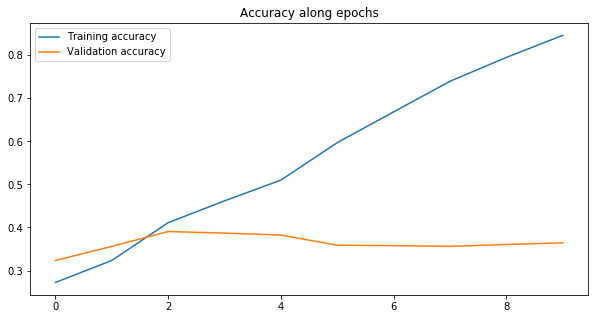

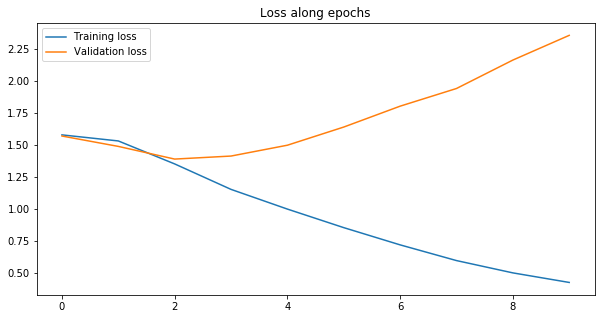

In [33]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)
import matplotlib.pyplot as plt

bs = 128
n_epochs = 10

history = model.fit(x_train_padded, 
                    y_train, 
                    batch_size=bs, 
                    epochs=n_epochs, 
                    validation_data=(x_dev_padded, y_dev))



### Plotting the evolution of train/dev results during epochs

# Accuracy
fig = plt.figure(figsize=(10,5))
plt.plot(history.history['acc'], label="Training accuracy")
plt.plot(history.history['val_acc'], label="Validation accuracy")
plt.legend()
plt.title("Accuracy along epochs")


# Loss
fig = plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Loss along epochs")

In [0]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# Re-training on the whole available labeled dataset

model.fit(pad_sequences(x_train_encoded+x_dev_encoded), 
          y_train+y_dev, 
          batch_size=bs, 
          epochs=n_epochs, 
          verbose=0)

with open("logreg_lstm_y_test_sst.txt","w+") as f:
    y_pred = np.argmax(model.predict(x_test_padded),1)
    for y in y_pred:
        f.write(str(y)+"\n")

## 4.3 - innovate !

In [0]:
### Pad sequences to same lengths
n_train =len(x_train)
n_dev = len(x_dev)
n_test = len(x_test)

x_all_padded = pad_sequences(x_train_encoded + x_dev_encoded + x_test_encoded)


x_train_padded = x_all_padded[:n_train,:]
x_dev_padded = x_all_padded[n_train:n_train+n_dev,:]
x_test_padded = x_all_padded[n_train+n_dev :,:]

y_train_cat=tf.keras.utils.to_categorical(y_train)
y_dev_cat=tf.keras.utils.to_categorical(y_dev)

In [267]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.
from tensorflow.keras.layers import  Conv1D, MaxPooling1D, Embedding, Bidirectional, Dropout, Flatten

vocab_size = 50000  # size of the vocabulary
n_classes  = 5
embed_dim = 150


model = Sequential()
model.add(Embedding(vocab_size, embed_dim, input_length=52))

model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(Dropout(0.5))

model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(n_classes, activation='softmax',
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
                activity_regularizer=tf.keras.regularizers.l1(0.01)))



###
## LR Scheduler
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
              0.001,
              decay_steps=2*n_train,
              decay_rate=1,
              staircase=False)

loss_classif     =  'categorical_crossentropy'
optimizer        =  'adam'
metrics_classif  =  ['accuracy']

print(model.summary())



model.compile(loss = loss_classif,
                  optimizer = tf.keras.optimizers.Adam(lr_schedule),
                  metrics = metrics_classif)

Model: "sequential_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_133 (Embedding)    (None, 52, 150)           7500000   
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 52, 128)           110080    
_________________________________________________________________
dropout_264 (Dropout)        (None, 52, 128)           0         
_________________________________________________________________
conv1d_230 (Conv1D)          (None, 50, 32)            12320     
_________________________________________________________________
max_pooling1d_230 (MaxPoolin (None, 25, 32)            0         
_________________________________________________________________
dropout_265 (Dropout)        (None, 25, 32)            0         
_________________________________________________________________
flatten_107 (Flatten)        (None, 800)            

Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 22s 3ms/sample - loss: 1.6597 - acc: 0.2603 - val_loss: 1.6291 - val_acc: 0.2598
Epoch 2/10
8544/8544 [==============================] - 11s 1ms/sample - loss: 1.6086 - acc: 0.2825 - val_loss: 1.5961 - val_acc: 0.2652
Epoch 3/10
8544/8544 [==============================] - 11s 1ms/sample - loss: 1.4730 - acc: 0.3717 - val_loss: 1.4368 - val_acc: 0.3806
Epoch 4/10
8544/8544 [==============================] - 11s 1ms/sample - loss: 1.1294 - acc: 0.5229 - val_loss: 1.4530 - val_acc: 0.3824
Epoch 5/10
8544/8544 [==============================] - 11s 1ms/sample - loss: 0.8347 - acc: 0.6772 - val_loss: 1.6603 - val_acc: 0.3660
Epoch 6/10
8544/8544 [==============================] - 11s 1ms/sample - loss: 0.6020 - acc: 0.7894 - val_loss: 2.0536 - val_acc: 0.3342
Epoch 7/10
8544/8544 [==============================] - 11s 1ms/sample - loss: 0.4496 - acc: 0.8508 - val_loss: 2.3536 - val_acc: 

Text(0.5, 1.0, 'Loss along epochs')

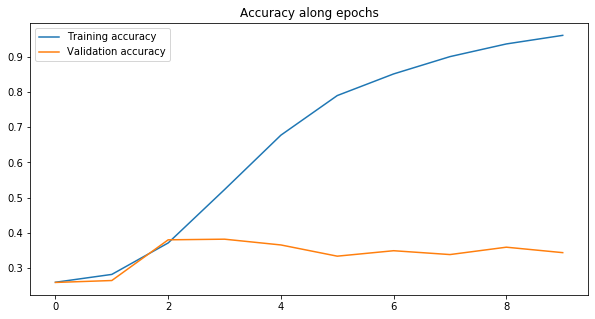

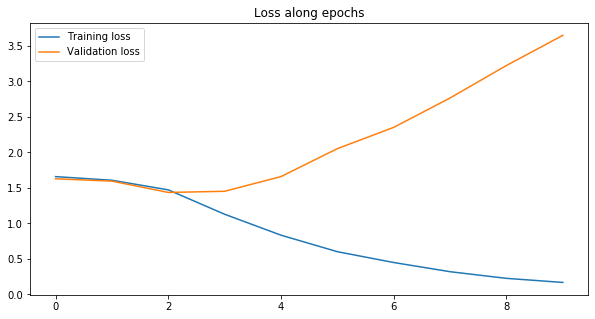

In [268]:
import matplotlib.pyplot as plt

n_epochs = 10
bs = 256

history = model.fit(x_train_padded, 
                    y_train_cat,
                    batch_size=bs,  
                    epochs=n_epochs, 
                    validation_data=(x_dev_padded, y_dev_cat))



### Plotting the evolution of train/dev results during epochs

# Accuracy
fig = plt.figure(figsize=(10,5))
plt.plot(history.history['acc'], label="Training accuracy")
plt.plot(history.history['val_acc'], label="Validation accuracy")
plt.legend()
plt.title("Accuracy along epochs")


# Loss
fig = plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Loss along epochs")

In [0]:
### Re-training on the whole available labeled dataset
model = Sequential()
model.add(Embedding(vocab_size, embed_dim, input_length=52))

model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(Dropout(0.5))

model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(n_classes, activation='softmax',
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
                activity_regularizer=tf.keras.regularizers.l1(0.01)))

model.compile(loss = loss_classif,
                  optimizer = tf.keras.optimizers.Adam(lr_schedule),
                  metrics = metrics_classif)


# Fitting
model.fit(np.concatenate((x_train_padded,x_dev_padded)), 
          np.concatenate((y_train_cat,y_dev_cat)), 
          batch_size=bs, 
          epochs=10, 
          verbose=0)

with open("cnn_bilstm_y_test_sst.txt","w+") as f:
    y_pred = np.argmax(model.predict(x_test_padded),1)
    for y in y_pred:
        f.write(str(y)+"\n")